<a href="https://colab.research.google.com/github/DamnScallion/Visionary-Unicorns-Project/blob/main/vgg/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/DamnScallion/Visionary-Unicorns-Project.git

Cloning into 'Visionary-Unicorns-Project'...
remote: Enumerating objects: 10956, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 10956 (delta 4), reused 3 (delta 0), pack-reused 10941
Receiving objects: 100% (10956/10956), 86.22 MiB | 14.18 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (10835/10835), done.


In [3]:
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import metrics
import os
import re
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

## Loading data

In [5]:
#loading all data into correct format

def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224)) #Input shape will change once images are processed
    img_array = np.array(img)
    return img_array

ROOT_DIR = '/content/Visionary-Unicorns-Project/'

#pathnames
train_file = f'{ROOT_DIR}data/original/train_annotations'
valid_file = f'{ROOT_DIR}data/original/valid_annotations'
augmented_annotations = f'{ROOT_DIR}data/augmented/augmented_train_annotation.txt'


train_labels = []
train_images = []
train_image_file = []
val_labels = []
val_images = []

#adding original image train labels
with open(train_file, "r") as f:
    for line in f:
        category_ids = re.findall(r'"category_id": [1,2]', line)
    for id in category_ids:
        train_labels.append(int(id[-1]) - 1)

#adding original train images
for file in sorted(os.listdir(f'{ROOT_DIR}data/original/train/')):
    train_image_file.append(file)
    img_path = os.path.join(f'{ROOT_DIR}data/original/train/', file)
    img = load_image(img_path)
    train_images.append(img)

#adding augmented train labels
with open(augmented_annotations, "r") as f:
    content = f.read()
    aug_category_ids = re.findall(r'"augmented_\d+\.jpg","category_id":[1,2]', content)
    #making a list of all augmented image file names for next step
    img_files = re.findall(r'augmented_\d+\.jpg', content)
    for id in aug_category_ids:
        train_labels.append(int(id[-1]) - 1)

#adding augmented image files
for file in img_files:
    train_image_file.append(file)
    img_path = os.path.join(f'{ROOT_DIR}data/augmented/train/', file)
    img = load_image(img_path)
    train_images.append(img)

#adding validation labels
with open(valid_file, "r") as f:
    for line in f:
        category_ids = re.findall(r'"category_id": [1,2]', line)
    for id in category_ids:
        val_labels.append(int(id[-1]) - 1)

#adding validation images
for file in sorted(os.listdir(f'{ROOT_DIR}data/original/valid/')):
    img_path = os.path.join(f'{ROOT_DIR}data/original/valid/', file)
    img = load_image(img_path)
    val_images.append(img)

#numpy arrays of images and labels for both sets
train_images = np.array(train_images)
val_images = np.array(val_images)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

#Normalize
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0

## Image augmentation

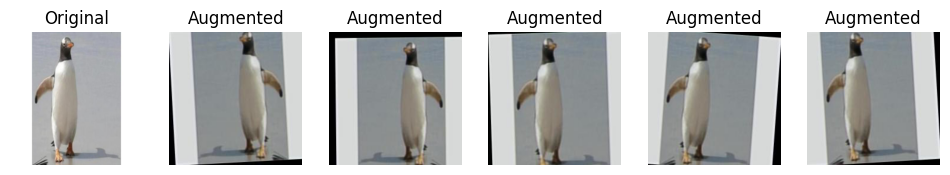

In [6]:
#plotting original and augemnted images
fig, axes = plt.subplots(1, 6, figsize=(12, 4))

axes[0].imshow(train_images[0])
axes[0].axis('off')
axes[0].set_title(f'Original')
for i in range(1,6):
    axes[i].imshow(train_images[i + 499])
    axes[i].axis('off')
    axes[i].set_title(f'Augmented')

plt.show()

## VGG16 model

In [7]:
#Getting pretrained VGG16 model
input_shape = (224, 224, 3)
baseModel = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
#Freezing pretrained model layers
baseModel.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
#building VGG16 model with new layers on the end to make it binary
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr = 5e-4
initial_model = keras.Sequential()
initial_model.add(baseModel)
initial_model.add(keras.layers.Flatten())
initial_model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
initial_model.add(keras.layers.Dropout(0.3))
initial_model.add(keras.layers.Dense(1, activation='sigmoid'))
initial_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])
#training
history = initial_model.fit(train_images, train_labels, batch_size=32, epochs=5, validation_data=(val_images, val_labels))

Epoch 1/5
94/94 [==============================] - 30s 179ms/step - loss: 1.6393 - accuracy: 0.8873 - val_loss: 0.7528 - val_accuracy: 0.8889
Epoch 2/5
94/94 [==============================] - 12s 126ms/step - loss: 0.4228 - accuracy: 0.9760 - val_loss: 0.4520 - val_accuracy: 0.9028
Epoch 3/5
94/94 [==============================] - 12s 128ms/step - loss: 0.2714 - accuracy: 0.9737 - val_loss: 0.3787 - val_accuracy: 0.9167
Epoch 4/5
94/94 [==============================] - 12s 130ms/step - loss: 0.2041 - accuracy: 0.9837 - val_loss: 0.3555 - val_accuracy: 0.9167
Epoch 5/5
94/94 [==============================] - 12s 132ms/step - loss: 0.1818 - accuracy: 0.9840 - val_loss: 0.3828 - val_accuracy: 0.8889


## VGG16 evaluation

In [9]:
val_predictions = initial_model.predict(val_images)
val_binary_predictions = (val_predictions > 0.5).astype(int)
# Calculate all evaluation metrics
conf_matrix = tf.math.confusion_matrix(val_labels, val_binary_predictions)
accuracy = metrics.Accuracy()(val_labels, val_binary_predictions)
precision = metrics.Precision()(val_labels, val_binary_predictions)
recall = metrics.Recall()(val_labels, val_binary_predictions)
f1 = 2 * (precision * recall) / (precision + recall)
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy", accuracy.numpy())
print("Precision:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1.numpy())

3/3 [==============================] - 1s 147ms/step
Confusion Matrix:
tf.Tensor(
[[30  6]
 [ 2 34]], shape=(2, 2), dtype=int32)
Accuracy 0.8888889
Precision: 0.85
Recall: 0.9444444
F1 Score: 0.8947368


## Custom VGG16 model with attention layer

In [10]:
#Code from https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
class ChannelAttention(tf.keras.layers.Layer):
  def __init__(self, filters, ratio):
    super(ChannelAttention, self).__init__()
    self.filters = filters
    self.ratio = ratio

  def build(self, input_shape):
    self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                                activation='relu', kernel_initializer='he_normal',
                                use_bias=True,
                                bias_initializer='zeros')
    self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                                kernel_initializer='he_normal',
                                use_bias=True,
                                bias_initializer='zeros')

  def call(self, inputs):
    # AvgPool
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


    avg_pool = self.shared_layer_one(avg_pool)
    avg_pool = self.shared_layer_two(avg_pool)

    # MaxPool
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
    max_pool = tf.keras.layers.Reshape((1,1,self.filters))(max_pool)

    max_pool = self.shared_layer_one(max_pool)
    max_pool = self.shared_layer_two(max_pool)


    attention = tf.keras.layers.Add()([avg_pool,max_pool])
    attention = tf.keras.layers.Activation('sigmoid')(attention)

    return tf.keras.layers.Multiply()([inputs, attention])

In [11]:
#Code from https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
class SpatialAttention(tf.keras.layers.Layer):
  def __init__(self, kernel_size):
    super(SpatialAttention, self).__init__()
    self.kernel_size = kernel_size

  def build(self, input_shape):
    self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                      kernel_size=self.kernel_size,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer='he_normal',
                      use_bias=False)

  def call(self, inputs):

  # AvgPool
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

    # MaxPool
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

    attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

    attention = self.conv2d(attention)


    return tf.keras.layers.multiply([inputs, attention])

In [12]:
#Custom VGG16 model with added attention layer and binary output

class AttentionVGG(keras.models.Model):
    def __init__(self, input_shape):
        super(AttentionVGG, self).__init__()
        #taking base model from VGG16 and freezing layers
        self.baseModel = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
        self.baseModel.trainable = False

        # attention layer
        self.conv_layer = keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')
        self.channel_attention = ChannelAttention(512, 8)
        self.spatial_attention = SpatialAttention(3)
        # fully connected layers with dropout added
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout = Dropout(0.4)
        self.dense2 = Dense(1, activation='sigmoid')


    def call(self, inputs):
        x = self.baseModel(inputs)
        x = self.conv_layer(x)
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        output = self.dense2(x)
        return output


In [13]:
input_shape = (224, 224, 3)
#Initialising custom model
model1 = AttentionVGG(input_shape=input_shape)
x = Input(shape=(224, 224, 3))
model = keras.models.Model(inputs=[x], outputs = model1.call(x))

lr = 5e-4
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["accuracy"])



In [14]:
#training
history = model.fit(train_images, train_labels, batch_size=32, epochs=5, validation_data=(val_images, val_labels))

Epoch 1/5
94/94 [==============================] - 19s 151ms/step - loss: 1.0092 - accuracy: 0.8940 - val_loss: 0.4134 - val_accuracy: 0.9167
Epoch 2/5
94/94 [==============================] - 14s 145ms/step - loss: 0.1014 - accuracy: 0.9840 - val_loss: 0.4373 - val_accuracy: 0.9028
Epoch 3/5
94/94 [==============================] - 14s 151ms/step - loss: 0.0408 - accuracy: 0.9960 - val_loss: 0.4787 - val_accuracy: 0.9167
Epoch 4/5
94/94 [==============================] - 14s 149ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.4487 - val_accuracy: 0.9028
Epoch 5/5
94/94 [==============================] - 14s 146ms/step - loss: 0.0402 - accuracy: 0.9907 - val_loss: 0.5196 - val_accuracy: 0.8889


## Custom model evaluation

In [15]:
val_predictions = model.predict(val_images)
val_binary_predictions = (val_predictions > 0.5).astype(int)
# Calculate all evaluation metrics
conf_matrix = tf.math.confusion_matrix(val_labels, val_binary_predictions)
accuracy = metrics.Accuracy()(val_labels, val_binary_predictions)
precision = metrics.Precision()(val_labels, val_binary_predictions)
recall = metrics.Recall()(val_labels, val_binary_predictions)
f1 = 2 * (precision * recall) / (precision + recall)
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy", accuracy.numpy())
print("Precision:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1.numpy())

3/3 [==============================] - 1s 106ms/step
Confusion Matrix:
tf.Tensor(
[[31  5]
 [ 3 33]], shape=(2, 2), dtype=int32)
Accuracy 0.8888889
Precision: 0.8684211
Recall: 0.9166667
F1 Score: 0.8918919


In [16]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         2359808   
                                                                 
 channel_attention (ChannelA  (None, 7, 7, 512)        66112     
 ttention)                                                       
                                                                 
 spatial_attention (SpatialA  (None, 7, 7, 512)        18        
 ttention)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0     

## Attention visualisation with GRAD CAM

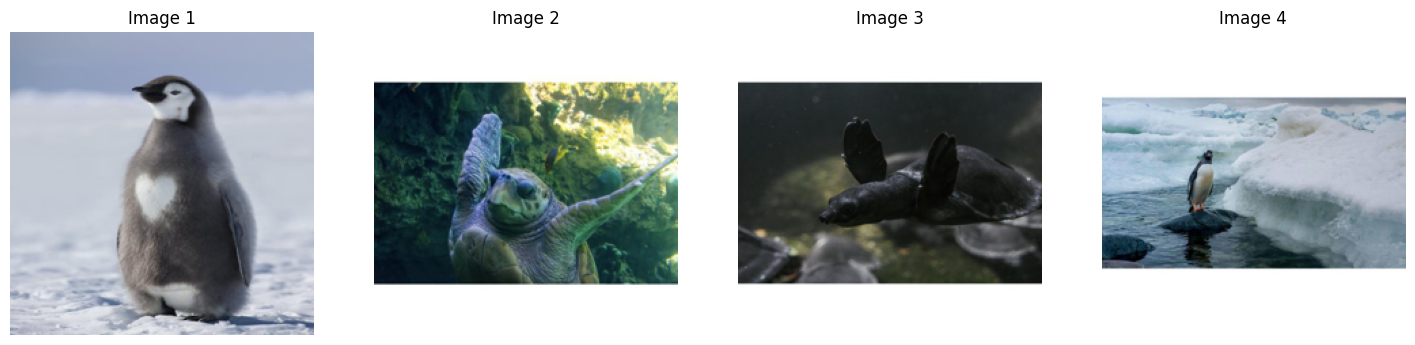

In [17]:
example1 = val_images[0]
example2 = val_images[10]
example3 = val_images[39]
example4 = val_images[56]

example_list = [example1, example2, example3, example4]


# example heatmaps
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i in range(4):
    axes[i].axis('off')  # Turn off axis ticks and labels
    axes[i].set_title(f'Image {i+1}')
    axes[i].imshow(example_list[i])


plt.show()

In [18]:
#GRAD CAM visualisation adapted from https://www.kaggle.com/code/ayuraj/gradcam-implementation-visualization-in-tf-w-b

#creating GRAD CAM heatmap
def make_gradcam_heatmap(img_array, model):
    # create model to extract prediction and output of last conv layer
    grad_model = keras.models.Model(
        model.inputs, [model.layers[2].output, model.output]
    )

    # calculate gradients of loss on last conv layer
    with tf.GradientTape() as tape:
        (last_conv_outputs, preds) = grad_model(img_array)
        loss = preds[0]
    grads = tape.gradient(loss, last_conv_outputs)

    #taking only positive gradients
    conv_outputs_binary = tf.cast(last_conv_outputs > 0, "float32")
    grads_binary = tf.cast(grads > 0, "float32")
    guidedGrads = conv_outputs_binary * grads_binary * grads

    #removing a dimension
    last_conv_outputs = last_conv_outputs[0]
    guidedGrads = guidedGrads[0]

    #Computing weights of each feature map
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))

    #Creating heatmap by taking sum of importance of each feature
    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_outputs), axis=-1)

    #resizing heatmap to match image
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))
    #normalising and converting to uint8
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.uint8(heatmap*255)

    return heatmap


In [19]:
#overlaying heatmap on image
def overlay_gradcam(heatmap, image):
    heatmap_converted = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = np.uint8(image * 255)
    output = cv2.addWeighted(image, 0.5, heatmap_converted, 0.5, 0)
    return output


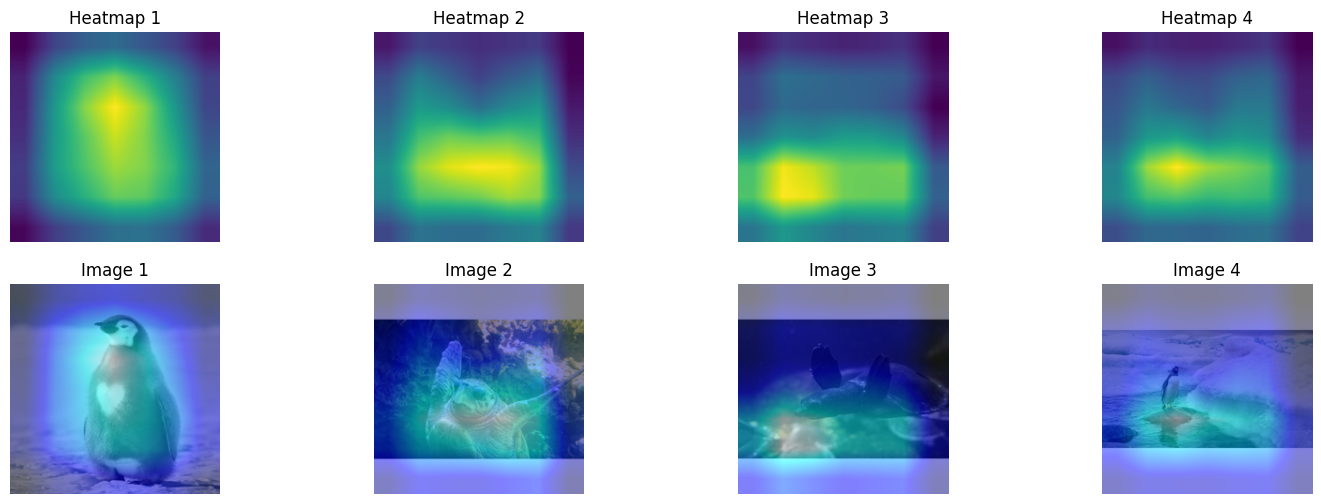

In [20]:
#showing heatmaps overliad on images
heatmap_list = []
overlay_list = []
for i in range(4):
    heatmap_list.append(make_gradcam_heatmap(np.expand_dims(example_list[i], axis=0), model))
    overlay_list.append(overlay_gradcam(heatmap_list[i], example_list[i]))


# example heatmaps
fig, axes = plt.subplots(2, 4, figsize=(18, 6))
for i in range(4):
    axes[1][i].axis('off')  # Turn off axis ticks and labels
    axes[1][i].set_title(f'Image {i+1}')
    axes[1][i].imshow(overlay_list[i])
for i in range(4):
    axes[0][i].axis('off')  # Turn off axis ticks and labels
    axes[0][i].set_title(f'Heatmap {i+1}')
    axes[0][i].imshow(heatmap_list[i])